In [2]:
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.utils.data as Data
from torchmetrics import Accuracy, Precision, Recall, F1Score, AUROC
import numpy as np
import h5py

from utils import EarlyStopping

In [3]:
# Initialize metrics
task = "binary"
accuracy = Accuracy(task)
precision = Precision(task)
recall = Recall(task)
f1_score = F1Score(task)
auroc = AUROC(task)

In [117]:
# Hyperparameters and constants
lr= 3E-4 #1E-2

batch_size = 32
epochs = 100   # define number of training epochs

# Data
frac_train = 0.7
frac_val = 0.10
frac_test = 0.20
# LR scheduler
step_size=10 # 10
gamma=0.7# 0.7 

In [118]:
# Define your loss function here
class Lossfunc(object):
    def __init__(self):
        self.loss = nn.BCELoss()
    def __call__(self, pred, target):
        return self.loss(pred, target)
    
# This reads the matlab data from the .mat file provided
# This reads the matlab data from the .mat file provided
class MatRead(object):
    def __init__(self, file_path):
        super(MatRead).__init__()
        self.file_path = file_path
        self.data = h5py.File(self.file_path)

    def get_load_apply(self):
        return torch.tensor(np.array(self.data['load_apply']).transpose(1,0), dtype=torch.float32)

    def get_result(self):
        return torch.tensor(np.array(self.data['result']).transpose(1,0), dtype=torch.float32)


In [83]:
######################### Data processing #############################
# Read data from .mat file
path = 'Data/Eiffel_data.mat' #Define your data path here
data_reader = MatRead(path)
x = data_reader.get_load_apply()
y = data_reader.get_result()

In [84]:
print(f"Feature is x.shape={x.shape}, Label is y.shape={y.shape}")

Feature is x.shape=torch.Size([1000, 20]), Label is y.shape=torch.Size([1000, 1])


In [71]:
x.isnan().sum().item(), y.isnan().sum().item()

(0, 0)

In [119]:
# Split the data into training and testing sets
ntrain = int(frac_train * x.shape[0])
nval = int(frac_val * x.shape[0])
ntest = x.shape[0] - ntrain - nval
x_train = x[:ntrain, ...]
y_train = y[:ntrain, ...]
x_val = x[ntrain:ntrain+nval, ...]
y_val = y[ntrain:ntrain+nval, ...]
x_test = x[ntrain+nval:, ...]
y_test = y[ntrain+nval:, ...]
ntrain,nval,ntest

(700, 100, 200)

In [120]:
# Define data normalizer
class DataNormalizer(object):
    """
    Input shape: (dataset_size, time_steps, 6) where 6 is the number of strain/ stress components (exx, eyy, ezz, exy, eyz, ezx).
    Normalize the strain/stress data to have range 0,1.
    """
    def __init__(self, data, epsilon=1e-4):
        self.epsilon = epsilon
        # Compute min and max across dataset_size and time_steps
        self.min = torch.amin(data, dim=0, keepdim=True)
        self.max = torch.amax(data, dim=0, keepdim=True)
        
        self.range = self.max - self.min
        # Prevent zero-range issues
        self.range = torch.where(self.range > self.epsilon, self.range, torch.tensor(1.0))
        
    @torch.no_grad()
    def normalize(self, data):
        return (data - self.min) / self.range

    def denormalize(self, data):
        return data * self.range + self.min
        
# Define data normalizer
class DataStandardizer(object):
    """
    Input shape: (dataset_size, time_steps, 6) where 6 is the number of strain/ stress components (exx, eyy, ezz, exy, eyz, ezx).
    Normalize the strain/stress data to have range 0,1.
    """
    def __init__(self, data, epsilon=1e-6):
        self.epsilon = epsilon
        # Compute mean and std across dataset_size and time_steps
        self.mean = torch.mean(data, dim=0)
        self.std = torch.std(data, dim=0)#+self.epsilon
        
    @torch.no_grad()
    def normalize(self, data):
        return (data - self.mean) / (self.std + self.epsilon)

    def denormalize(self, data):
        return data * self.std + self.mean

In [121]:
# Normalize your data
x_normalizer   = DataStandardizer(x_train)
x_train_encode = x_normalizer.normalize(x_train)
x_val_encode   = x_normalizer.normalize(x_val)
x_test_encode  = x_normalizer.normalize(x_test)

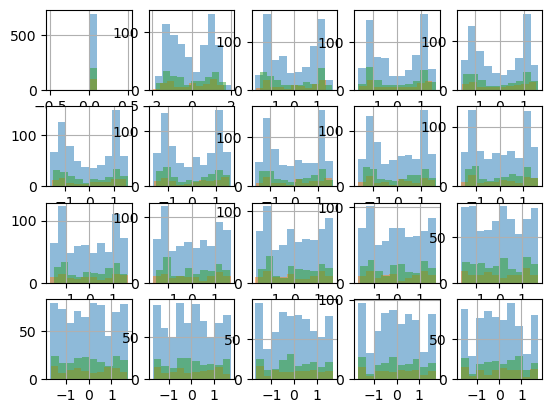

In [122]:
# Visualize a hisogram of the normalized data
plt.figure(1)
for i in range(20):
    plt.subplot(4, 5,i+1)
    plt.hist(x_train_encode[:,i].flatten().numpy(), bins=10, alpha=0.5, label='x_train')
    plt.hist(x_val_encode[:,i].flatten().numpy(), bins=10, alpha=0.5, label='x_val')
    plt.hist(x_test_encode[:,i].flatten().numpy(), bins=10, alpha=0.5, label='x_test')
    plt.grid()
    #plt.xlabel('Normalized Load')
    #plt.ylabel('Frequency')
#plt.legend()

In [90]:
ndim = x.shape[1]  # Number of components
ndim

20

In [123]:
# Create data loader
train_set = Data.TensorDataset(x_train_encode, y_train)
val_set = Data.TensorDataset(x_val_encode, y_val)
test_set = Data.TensorDataset(x_test_encode, y_test)
train_loader = Data.DataLoader(train_set, batch_size, shuffle=True)
val_loader = Data.DataLoader(val_set, batch_size, shuffle=False)
test_loader = Data.DataLoader(test_set, batch_size, shuffle=False)

In [129]:
# Define your neural network here
from models import UNet1DClassifier

net = UNet1DClassifier(num_layers=1,hidden_dim=200)
n_params = sum(p.numel() for p in net.parameters() if p.requires_grad) #Calculate the number of training parameters
print('Number of parameters: %d' % n_params)

Number of parameters: 910257


In [130]:
loss_func = Lossfunc() #define loss function
optimizer = torch.optim.Adam(net.parameters(), lr=lr) #define optimizer
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size,gamma=gamma) #define learning rate scheduler
early_stopping = EarlyStopping(patience=80, min_delta=0.0005)

In [131]:
# Train network
loss_train_list = []
loss_val_list = []

acc_train_list = []
acc_val_list = []

prec_train_list = []
prec_val_list = []

rec_train_list = []
rec_val_list = []

f1_train_list = []
f1_val_list = []

auc_train_list = []
auc_val_list = []

In [132]:
print("Start training for {} epochs...".format(epochs))

for epoch in range(epochs):
    net.train(True)
    
    outputs_train = []
    outputs_val = []
    targets_train_list = []
    train_loss = 0.

    for i, data in enumerate(train_loader):
        optimizer.zero_grad()
        input, target = data
        #define forward neural network evaluation below
        output = net(input)
        #cache the outputs along axis 0 to compute metrics
        loss = loss_func(output, target)
        loss.backward()
        optimizer.step()
        scheduler.step()
        train_loss += loss.item()
        outputs_train.append(output.detach().cpu())
        targets_train_list.append(target.detach().cpu())
        
    outputs_train = torch.cat(outputs_train, dim=0)
    targets_train = torch.cat(targets_train_list, dim=0)
    
    # Compute train metrics per epoch
    train_loss = round(train_loss/len(train_loader),5)
    loss_train_list.append(round(train_loss,3))
    acc_train_list.append(round(accuracy(outputs_train, targets_train).item(),3))
    prec_train_list.append(round(precision(outputs_train, targets_train).item(),3))
    rec_train_list.append(round(recall(outputs_train, targets_train).item(),3))
    f1_train_list.append(round(f1_score(outputs_train, targets_train).item(),3))
    auc_train_list.append(round(auroc(outputs_train, targets_train).item(),3))

    # Compute your val loss below
    net.eval()
    val_loss = 0.
    with torch.no_grad():
        for i, data in enumerate(val_loader):
            input, target = data
            output = net(input)
            outputs_val.append(output)
            loss = loss_func(output, target)
            val_loss += loss.item()
             
    outputs_val = torch.cat(outputs_val, dim=0)
    # Compute val metrics per epoch
    val_loss = round(val_loss/len(val_loader),5)
    loss_val_list.append(val_loss)
    acc_val_list.append(round(accuracy(outputs_val, y_val).item(),3))
    prec_val_list.append(round(precision(outputs_val, y_val).item(),3))
    rec_val_list.append(round(recall(outputs_val, y_val).item(),3))
    f1_val_list.append(round(f1_score(outputs_val, y_val).item(),3))
    auc_val_list.append(round(auroc(outputs_val, y_val).item(),3))
    
    # Print train loss every 10 epochs
    if (epoch % 10 == 0):
        print("epoch:{}, train loss:{}, val loss:{}, train acc:{}, val acc:{}".format(epoch, train_loss, val_loss, acc_train_list[-1], acc_val_list[-1]))
    
    # Check early stopping
    early_stopping(val_loss)
    if early_stopping.early_stop:
        break  # Stop training if triggered

print("Training complete!")

print(f"""
FINAL TRAIN METRICS: 
loss={loss_train_list[-1]},
acc={acc_train_list[-1]}, 
prec={prec_train_list[-1]}, 
rec={rec_train_list[-1]}, 
f1={f1_train_list[-1]}, 
auroc={auc_train_list[-1]}
____________________________________________________
""")

print(f"""
Final VAL METRICS:
loss={loss_val_list[-1]},
acc={acc_val_list[-1]}, 
prec={prec_val_list[-1]}, 
rec={rec_val_list[-1]}, 
f1={f1_val_list[-1]}, 
auroc={auc_val_list[-1]}
____________________________________________________
""")

torch.save(net.state_dict(), 'unet_p_model.pth')

Start training for 100 epochs...
epoch:0, train loss:0.49117, val loss:0.3668, train acc:0.844, val acc:0.95
epoch:10, train loss:0.23418, val loss:0.21017, train acc:0.934, val acc:0.95
epoch:20, train loss:0.24454, val loss:0.21029, train acc:0.937, val acc:0.96
epoch:30, train loss:0.25611, val loss:0.20327, train acc:0.93, val acc:0.98
epoch:40, train loss:0.27236, val loss:0.20664, train acc:0.91, val acc:0.97
epoch:50, train loss:0.24193, val loss:0.21073, train acc:0.92, val acc:0.95
epoch:60, train loss:0.23552, val loss:0.20704, train acc:0.939, val acc:0.96
epoch:70, train loss:0.24362, val loss:0.21031, train acc:0.939, val acc:0.95
epoch:80, train loss:0.23203, val loss:0.20491, train acc:0.941, val acc:0.98
epoch:90, train loss:0.25079, val loss:0.20511, train acc:0.923, val acc:0.98
Training complete!

FINAL TRAIN METRICS: 
loss=0.239,
acc=0.934, 
prec=0.915, 
rec=0.921, 
f1=0.918, 
auroc=0.986
____________________________________________________


Final VAL METRICS:
loss

In [133]:
#save the loss_train_list values for plotting
from numpy import save as np_save 
np_save('task_b_unet_p_loss_train.npy', loss_train_list)

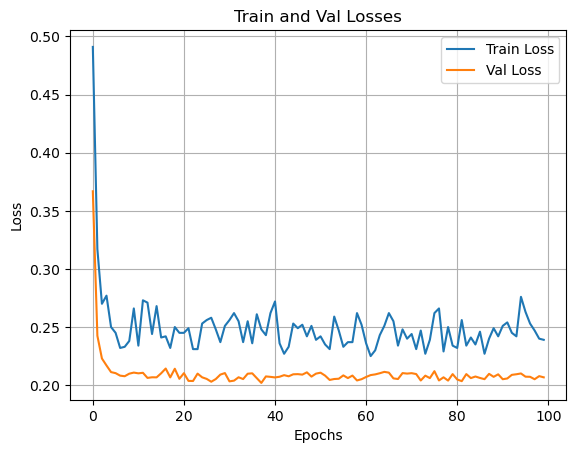

In [134]:
############################# Plot your result below using Matplotlib #############################
plt.figure(1)
plt.plot(loss_train_list, label='Train Loss')
plt.plot(loss_val_list, label='Val Loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Train and Val Losses')
plt.savefig("task_b_unet_p_loss.png")

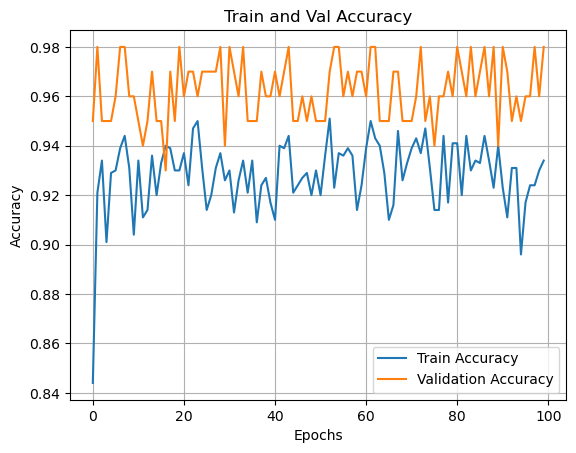

In [135]:
############################# Plot your result below using Matplotlib #############################
plt.figure(1)
plt.plot(acc_train_list, label='Train Accuracy')
plt.plot(acc_val_list, label='Validation Accuracy')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Train and Val Accuracy')
plt.savefig("task_b_unet_p_acc.png")

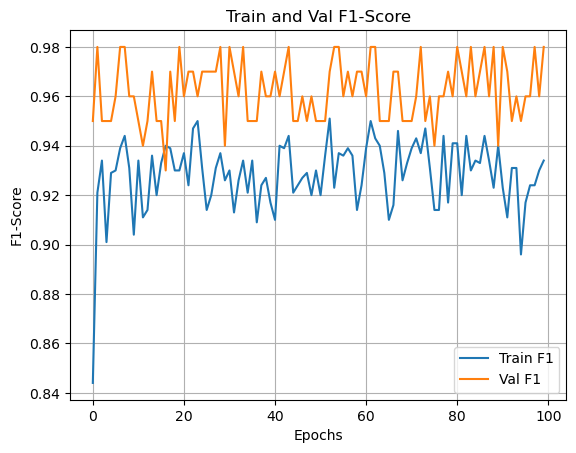

In [136]:
############################# Plot your result below using Matplotlib #############################
plt.figure(1)
plt.plot(acc_train_list, label='Train F1')
plt.plot(acc_val_list, label='Val F1')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('F1-Score')
plt.title('Train and Val F1-Score')
plt.savefig("task_b_unet_p_f1.png")

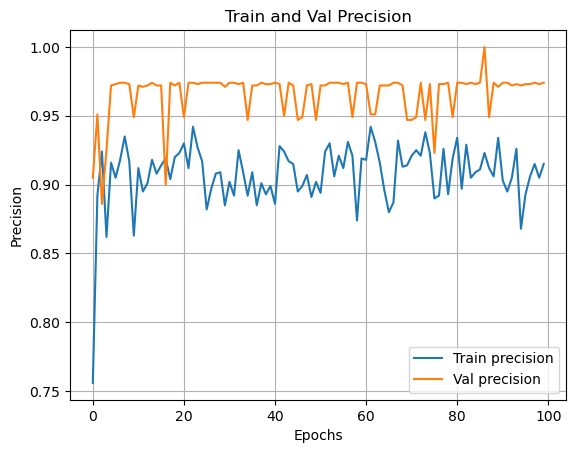

In [137]:
############################# Plot your result below using Matplotlib #############################
plt.figure(1)
plt.plot(prec_train_list, label='Train precision')
plt.plot(prec_val_list, label='Val precision')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Precision')
plt.title('Train and Val Precision')
plt.savefig("task_b_unet_p_prec.png")

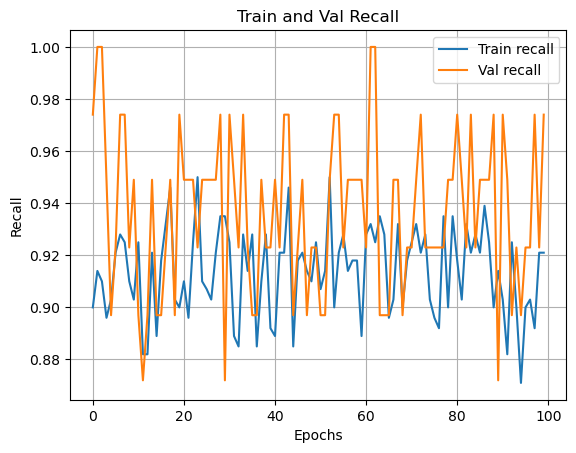

In [138]:
############################# Plot your result below using Matplotlib #############################
plt.figure(1)
plt.plot(rec_train_list, label='Train recall')
plt.plot(rec_val_list, label='Val recall')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('Recall')
plt.title('Train and Val Recall')
plt.savefig("task_b_unet_p_recall.png")

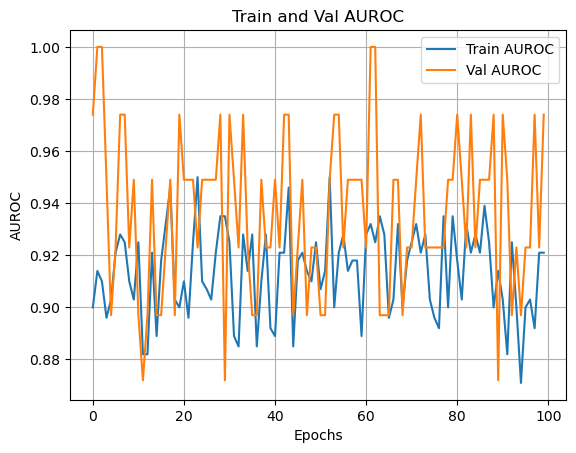

In [139]:
############################# Plot your result below using Matplotlib #############################
plt.figure(1)
plt.plot(rec_train_list, label='Train AUROC')
plt.plot(rec_val_list, label='Val AUROC')
plt.legend()
plt.grid()
plt.xlabel('Epochs')
plt.ylabel('AUROC')
plt.title('Train and Val AUROC')
plt.savefig("task_b_unet_p_auroc.png")

In [140]:
# Compute your TEST loss below
net.eval()
test_loss = 0.
outputs_test = []
loss_test = None
acc_test = None
prec_test = None
rec_test = None
f1_test = None
auc_test = None
with torch.no_grad():
    for i, data in enumerate(test_loader):
        input, target = data
        output = net(input)
        outputs_test.append(output)
        loss = loss_func(output, target)
        test_loss += loss.item()
         
outputs_test = torch.cat(outputs_test, dim=0)
# Compute val metrics per epoch
loss_test = round(test_loss/len(test_loader),5)     
acc_test=round(accuracy(outputs_test, y_test).item(),3)
prec_test=round(precision(outputs_test, y_test).item(),3)
rec_test=round(recall(outputs_test, y_test).item(),3)
f1_test=round(f1_score(outputs_test, y_test).item(),3)
auc_test=round(auroc(outputs_test, y_test).item(),3)

print(f"""
FINAL TEST METRICS:
loss={loss_test},
acc={acc_test},
prec={prec_test},
rec={rec_test},
f1={f1_test},
auroc={auc_test}
____________________________________________________
""")


FINAL TEST METRICS:
loss=0.23401,
acc=0.965,
prec=0.988,
rec=0.929,
f1=0.958,
auroc=0.996
____________________________________________________



### Hyperparameter Optimization (Bayesian/Genetic Algorithm for online pruning of search space)

In [ ]:
# Advanced optimization
% conda install optuna

In [30]:
import optuna

def objective_train(trial):
    # Sample training hyperparameters
    lr = trial.suggest_loguniform('lr', 1e-5, 0.1)
    batch_size = trial.suggest_categorical('batch_size', [16, 32, 64])
    step_size = trial.suggest_int('step_size', 5, 20)
    gamma = trial.suggest_float('gamma', 0.1, 0.9)
    
    # Create DataLoaders
    train_set = Data.TensorDataset(x_train_encode, y_train)
    val_set   = Data.TensorDataset(x_val_encode, y_val)
    train_loader = Data.DataLoader(train_set, batch_size=batch_size, shuffle=True)
    val_loader   = Data.DataLoader(val_set, batch_size=batch_size, shuffle=False)
    
    # Build fixed architecture network
    net = UNet1DClassifier()
    loss_func = Lossfunc()
    optimizer = torch.optim.Adam(net.parameters(), lr=lr)
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=step_size, gamma=gamma)
    
    num_epochs = 50  # fewer epochs for faster hyperparameter search
    best_val_loss = float('inf')
    for epoch in range(num_epochs):
        net.train()
        for inputs, targets in train_loader:
            optimizer.zero_grad()
            outputs = net(inputs)
            loss = loss_func(outputs, targets)
            loss.backward()
            optimizer.step()
            scheduler.step()
        
        net.eval()
        val_loss = 0.0
        with torch.no_grad():
            for inputs, targets in val_loader:
                outputs = net(inputs)
                loss = loss_func(outputs, targets)
                val_loss += loss.item()
        val_loss /= len(val_loader)
        
        trial.report(val_loss, epoch)
        if trial.should_prune():
            raise optuna.exceptions.TrialPruned()
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            
    return best_val_loss

# Run Stage 1 optimization
study_train = optuna.create_study(direction="minimize")
study_train.optimize(objective_train, n_trials=200)
print("Stage 1 (Training hyperparameters) Best trial:")
for key, value in study_train.best_trial.params.items():
    print(f"  {key}: {value}")

best_train_params = study_train.best_trial.params

[I 2025-02-25 22:00:16,369] A new study created in memory with name: no-name-5e2354e9-1654-4e71-b412-326833d6c961
/tmp/ipykernel_970772/2028115441.py:5: FutureWarning: suggest_loguniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use suggest_float(..., log=True) instead.
  lr = trial.suggest_loguniform('lr', 1e-5, 0.1)
[I 2025-02-25 22:00:37,447] Trial 0 finished with value: 0.6162876635789871 and parameters: {'lr': 0.0003119169601593087, 'batch_size': 32, 'step_size': 5, 'gamma': 0.8317944872429764}. Best is trial 0 with value: 0.6162876635789871.
[I 2025-02-25 22:00:58,074] Trial 1 finished with value: 0.6812122762203217 and parameters: {'lr': 7.400143190555842e-05, 'batch_size': 32, 'step_size': 11, 'gamma': 0.5240091182663976}. Best is trial 0 with value: 0.6162876635789871.
[I 2025-02-25 22:01:19,447] Trial 2 finished with value: 0.6905810683965683 and parameters: {'lr': 1.464756031280816e-05, 'b

Stage 1 (Training hyperparameters) Best trial:
  lr: 0.009080526888576862
  batch_size: 16
  step_size: 10
  gamma: 0.8543564738341566
